# v1nyl

In [24]:
import os
import tensorflow as tf
import tensorflow.contrib.rnn as rnn
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import h5py as h5
import data_utils as du

In [27]:
x = np.zeros((5,5))
y = np.ones((5,5))
loss = np.sum(np.absolute(y-x))
print(loss)

25.0


In [36]:
def plot_time_step(slices):
	num_slice,_,_,_ = slices.shape
	print(num_slice)
	slices = slices.transpose(0,2,1,3)
#	slices = tf.transpose(slices, perm=[0,2,1,3])
#	print(slices.dtype)
	for s in range(num_slice):
		fig = plt.figure(s)
		# a = plt.subplot(num_slice, 1, 1+s)
		plt.imshow(1-np.abs(slices[s,:,:,0]), cmap='gray')
#		print(slices[s,:,:,0].dtype.base_dtype)
# 		plt.imshow(slices[s,:,:,0], cmap='gray')
#		plt.imshow(slices[s,:,:,0])
		plt.title("%d" % s)
	plt.show()
    
def plot_time_diff(slices):
    num_slice,_,_,_ = slices.shape
    print(num_slice)
    slices = slices.transpose(0,2,1,3)
    fig = plt.figure(0)
    plt.imshow(np.abs(slices[0,:,:,0]), cmap='gray')
    plt.title("t=0")
    for s in range(num_slice-1):
        fig = plt.figure(s+1)
        plt.imshow(np.abs(slices[s+1,:,:,0])-np.abs(slices[s,:,:,0]), cmap='gray')
        plt.title("t=(%d-%d)"% ((s+1), s))
    plt.show()

In [37]:
num_train, num_val, num_test = 70, 10, 20

train_data,val_data,test_data = du.create_dicts(num_train, num_val, num_test)
# maxX,maxY,maxT = du.init() # call once

In [38]:
# Creates h5 files of the data, each patient is a dataset
# du.train_h5(train_data, maxX, maxY, maxT)
# du.val_h5(val_data, maxX, maxY, maxT)
# du.test_h5(test_data, maxX, maxY, maxT)

# Creates tfrecords files where data is sorted slice-by-slice, in chunks of (T,H,W,C)
# du.what_tf('train', train_data)
# du.what_tf('val', val_data)
# du.what_tf('test', test_data)

# Creates tfrecords files where data is sorted image-by-image, in chunks of (H,W,C)
# du.what_tf_fcn8('train', train_data)
# du.what_tf_fcn8('val', val_data)
# du.what_tf_fcn8('test', test_data)

(80, 18, 224, 192, 1)
complex64
17


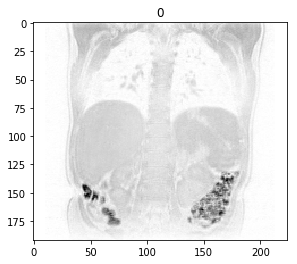

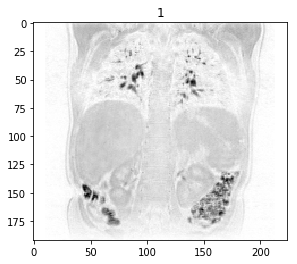

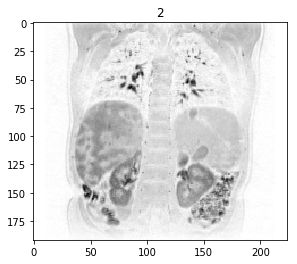

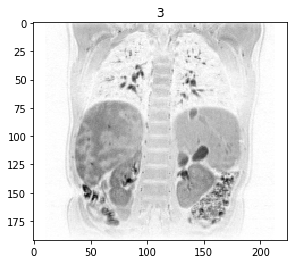

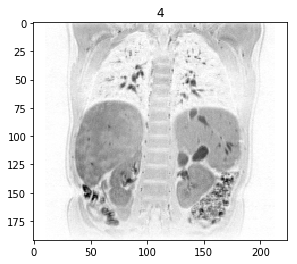

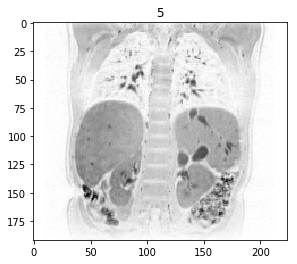

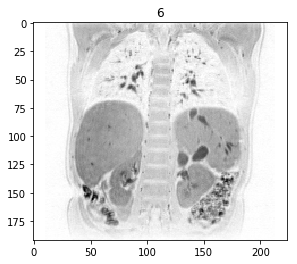

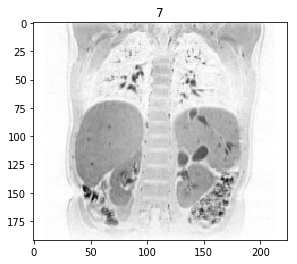

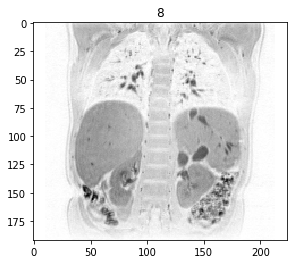

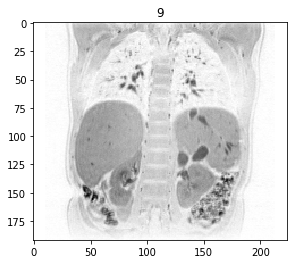

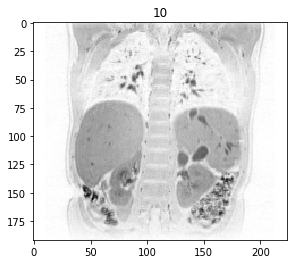

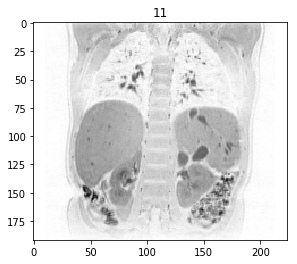

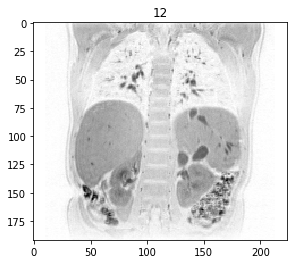

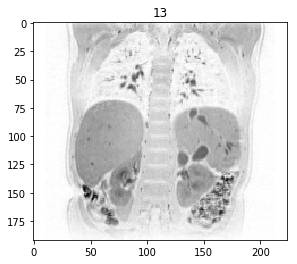

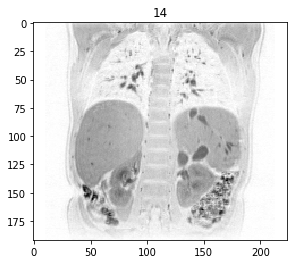

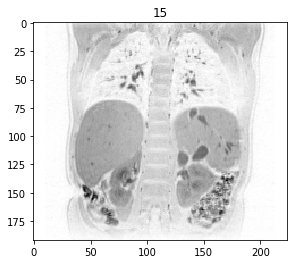

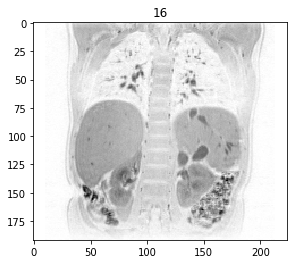

17


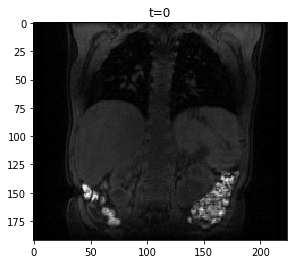

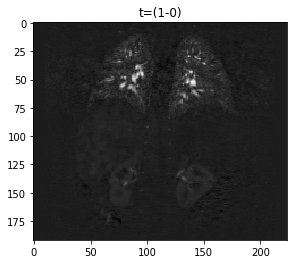

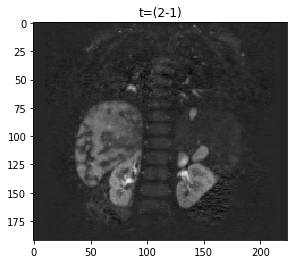

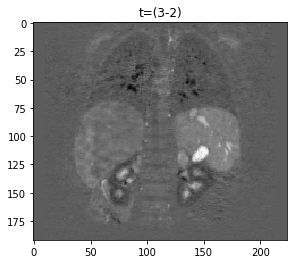

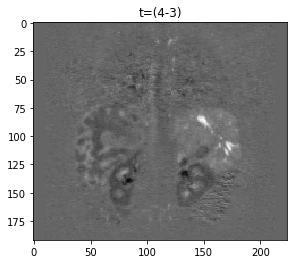

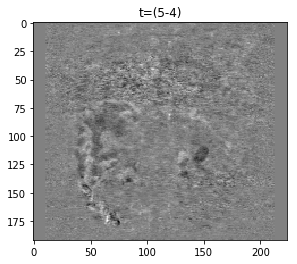

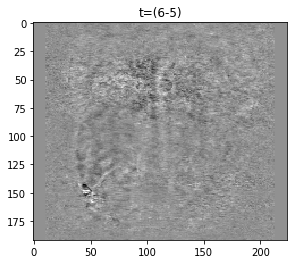

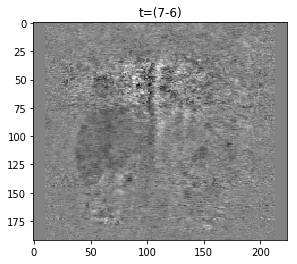

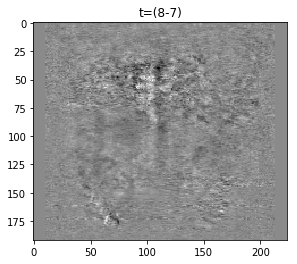

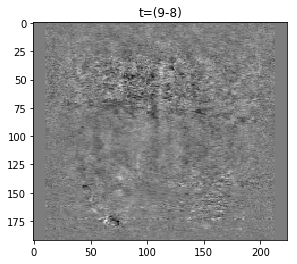

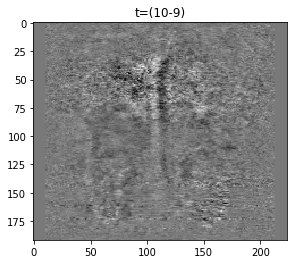

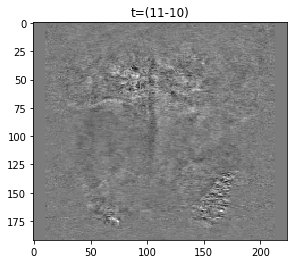

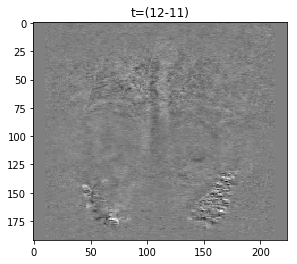

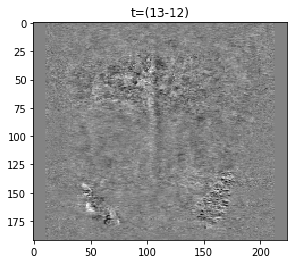

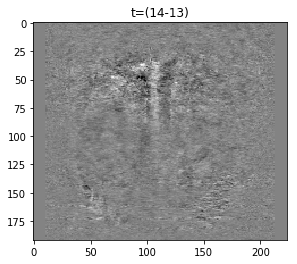

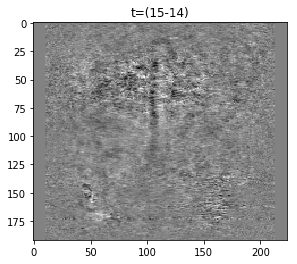

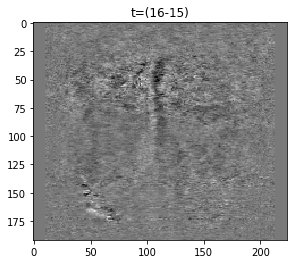

In [39]:
# fc = h5.File('datasets/train_curr.h5', 'r')
# fn = h5.File('datasets/train_next.h5', 'r')
# print(fc[train_data[0]].shape)
# print(fn[train_data[0]].shape)
# plot_time_step(fc[train_data[0]][510], fn[train_data[0]][510])
f = h5.File('datasets/train.h5', 'r')
print(f[train_data[0]].shape)
print(f[train_data[0]].dtype)
plot_time_step(f[train_data[0]][25,1:18,:,:,:])
plot_time_diff(f[train_data[0]][25,1:18,:,:,:])
f.close()

In [3]:
MODEL_NAME = 'model-004'

In [ ]:
class ConvLSTMCell(tf.nn.rnn_cell.RNNCell):
  """A LSTM cell with convolutions instead of multiplications.
  Reference:
    Xingjian, S. H. I., et al. "Convolutional LSTM network: A machine learning approach for precipitation nowcasting." Advances in Neural Information Processing Systems. 2015.
  """

  def __init__(self, shape, filters, kernel, forget_bias=1.0, activation=tf.tanh, normalize=True, peephole=True, data_format='channels_last', reuse=None):
    super(ConvLSTMCell, self).__init__(_reuse=reuse)
    self._kernel = kernel
    self._filters = filters
    self._forget_bias = forget_bias
    self._activation = activation
    self._normalize = normalize
    self._peephole = peephole
    if data_format == 'channels_last':
        self._size = tf.TensorShape(shape + [self._filters])
        self._feature_axis = self._size.ndims
        self._data_format = None
    elif data_format == 'channels_first':
        self._size = tf.TensorShape([self._filters] + shape)
        self._feature_axis = 0
        self._data_format = 'NC'
    else:
        raise ValueError('Unknown data_format')

  @property
  def state_size(self):
    return tf.nn.rnn_cell.LSTMStateTuple(self._size, self._size)

  @property
  def output_size(self):
    return self._size

  def call(self, x, state):
    c, h = state

    x = tf.concat([x, h], axis=self._feature_axis)
    n = x.shape[-1].value
    m = 4 * self._filters if self._filters > 1 else 4
    W = tf.get_variable('kernel', self._kernel + [n, m])
    y = tf.nn.convolution(x, W, 'SAME', data_format=self._data_format)
    if not self._normalize:
      y += tf.get_variable('bias', [m], initializer=tf.zeros_initializer())
    j, i, f, o = tf.split(y, 4, axis=self._feature_axis)

    if self._peephole:
      i += tf.get_variable('W_ci', c.shape[1:]) * c
      f += tf.get_variable('W_cf', c.shape[1:]) * c

    if self._normalize:
      j = tf.contrib.layers.layer_norm(j)
      i = tf.contrib.layers.layer_norm(i)
      f = tf.contrib.layers.layer_norm(f)

    f = tf.sigmoid(f + self._forget_bias)
    i = tf.sigmoid(i)
    c = c * f + i * self._activation(j)

    if self._peephole:
      o += tf.get_variable('W_co', c.shape[1:]) * c

    if self._normalize:
      o = tf.contrib.layers.layer_norm(o)
      c = tf.contrib.layers.layer_norm(c)

    o = tf.sigmoid(o)
    h = o * self._activation(c)

    state = tf.nn.rnn_cell.LSTMStateTuple(c, h)

    return h, state

In [ ]:
# Initial ConvLSTM-based model

def model_fn(features,
             labels,
             mode,
             params):
    with tf.device('/device:GPU:0'):
    
        img_curr = features
        img_next = labels
    
        inputs = img_curr
    
        #tf.summary.image('input', inputs[0,:,:,:,:], max_outputs=200)
    
        #print(inputs.get_shape())
    
        #inputs = tf.split(value=img_curr, num_or_size_splits=17)
        #print('inputs={}'.format(inputs))
    
        convlstm_cell = rnn.Conv2DLSTMCell(
            input_shape=[224, 192, 1],
            output_channels=1,
            kernel_shape=[5,5],
            use_bias=True,
            skip_connection=False,
            forget_bias=params.forget_bias
        )
    
        outputs, _ = tf.nn.dynamic_rnn(
            cell=convlstm_cell,
            inputs=inputs,
            dtype=tf.float32
        )
    
        print('outputs={}'.format(outputs))
    
        # Adds output predictions to be displayed in TensorBoard
        #tf.summary.image('output', outputs[0,:,:,:,:], max_outputs=200)
    
        disp = tf.concat([inputs[0,:,:,:,:], outputs[0,:,:,:,:]], 1)
        tf.summary.image('concat', disp, max_outputs=200)
    
        predictions = {'results': outputs}
    
        if mode == tf.estimator.ModeKeys.PREDICT:
            export_outputs = {
                'predictions': tf.estimator.export.PredictOutput(outputs)
            }
            return tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=outputs
            )
    
        loss = tf.losses.mean_squared_error(img_next, outputs)
    
        optimizer = tf.train.AdamOptimizer(
            learning_rate=params.learning_rate,
            beta1=params.beta1,
            beta2=params.beta2,
            epsilon=params.epsilon
        )
    
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(
                loss=loss, global_step=tf.train.get_global_step())
    
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(img_next, outputs),
            "mae": tf.metrics.mean_absolute_error(img_next, outputs),
            "mse": tf.metrics.mean_squared_error(img_next, outputs)
        }
    
        estimator_spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=eval_metric_ops
        )
        
        return estimator_spec

In [ ]:
# Simple model function using just a single conv-deconv

def model_fn(features,
             labels,
             mode,
             params):
    with tf.device('/device:GPU:0'):
        inputs = features
        
        conv_out = tf.layers.conv2d(inputs, filters=32, kernel_size=5, strides=1, padding='same')
        
        outputs = tf.layers.conv2d_transpose(conv_out, filters=1, kernel_size=5, strides=1, padding='same')
    
        # Adds output predictions to be displayed in TensorBoard
        #tf.summary.image('output', outputs[0,:,:,:,:], max_outputs=200)
        
        # Adds concatenated inputs and outputs to be displayed in TensorBoard
        disp = tf.concat([inputs[:,:,:], outputs[:,:,:]], 1)
        tf.summary.image('concat', disp, max_outputs=200)
    
        predictions = {'results': outputs}
    
        if mode == tf.estimator.ModeKeys.PREDICT:
            export_outputs = {
                'predictions': tf.estimator.export.PredictOutput(outputs)
            }
            return tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=outputs
            )
        
        if mode == tf.estimator.ModeKeys.EVAL:
            disp = tf.concat([inputs[:,:,:], outputs[:,:,:]], 1)
            tf.summary.image('concat', disp, max_outputs=200)
    
        loss = tf.losses.mean_squared_error(labels, outputs)
    
        optimizer = tf.train.AdamOptimizer(
            learning_rate=params.learning_rate,
            beta1=params.beta1,
            beta2=params.beta2
        )
    
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(
                loss=loss, global_step=tf.train.get_global_step())
    
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(labels, outputs),
            "mae": tf.metrics.mean_absolute_error(labels, outputs),
            "mse": tf.metrics.mean_squared_error(labels, outputs)
        }
    
        estimator_spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=eval_metric_ops
        )
        
        return estimator_spec

In [7]:
# Attempting that FCN8-based model, t->t+1

def model_fn(features,
             labels,
             mode,
             params):
    with tf.device('/device:GPU:0'):
        inputs = features
        tf.summary.image('input', inputs, max_outputs=200)
        
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 1, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(inputs, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv1_1 = tf.nn.relu(out, name=scope)
        
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv1_2 = tf.nn.relu(out, name=scope)
        
        #pool1 = tf.layers.max_pooling2d(conv1_2, pool_size=2, strides=2, padding='SAME')
        
        pool1 = tf.nn.max_pool(conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')
        
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv2_1 = tf.nn.relu(out, name=scope)
            
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv2_2 = tf.nn.relu(out, name=scope)
        
        pool2 = tf.nn.max_pool(conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')
        
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv3_1 = tf.nn.relu(out, name=scope)
            
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv3_2 = tf.nn.relu(out, name=scope)
        
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv3_3 = tf.nn.relu(out, name=scope)
        
        pool3 = tf.nn.max_pool(conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')
        
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv4_1 = tf.nn.relu(out, name=scope)
            
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv4_2 = tf.nn.relu(out, name=scope)
        
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv4_3 = tf.nn.relu(out, name=scope)
        
        pool4 = tf.nn.max_pool(conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')
        
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv5_1 = tf.nn.relu(out, name=scope)
            
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv5_2 = tf.nn.relu(out, name=scope)
        
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv5_3 = tf.nn.relu(out, name=scope)
        
        pool5 = tf.nn.max_pool(conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool5')
        
        with tf.name_scope('fc6') as scope:
            kernel = tf.Variable(tf.truncated_normal([1, 1, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(pool5, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            fc6 = tf.nn.relu(out, name=scope)
            
        with tf.name_scope('fc7') as scope:
            kernel = tf.Variable(tf.truncated_normal([1, 1, 512, 4096], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(fc6, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            fc7 = tf.nn.relu(out, name=scope)
        
        fcn8 = tf.layers.conv2d(fc7, filters=1000, kernel_size = 1)
        fcn9 = tf.layers.conv2d_transpose(fcn8, filters=pool4.get_shape().as_list()[-1],
                                          kernel_size=4, strides=2, padding='SAME')
        fcn9_skip = tf.add(fcn9, pool4)
        fcn10= tf.layers.conv2d_transpose(fcn9_skip, filters=pool3.get_shape().as_list()[-1],
                                          kernel_size=4, strides=2, padding='SAME')
        fcn10_skip= tf.add(fcn10, pool3)
        outputs = tf.layers.conv2d_transpose(fcn10_skip, filters=1,
                                             kernel_size=16, strides=8, padding='SAME')
        max_outputs = tf.reduce_max(outputs, axis=[1,2,3])
        max_outputs = tf.expand_dims(tf.expand_dims(tf.expand_dims(max_outputs, -1),-1),-1)
        outputs = tf.divide(outputs, max_outputs)
        outputs = inputs + outputs
        
        # Adds concatenated inputs and outputs to be displayed in TensorBoard
#         disp = tf.concat([inputs, labels, outputs], 1)
#         tf.summary.image('concat', disp, max_outputs=200)
        tf.summary.image('outputs', outputs, max_outputs=200)
        tf.summary.image('labels', labels, max_outputs=200)
    
        predictions = {'results': outputs}
    
        if mode == tf.estimator.ModeKeys.PREDICT:
            export_outputs = {
                'predictions': tf.estimator.export.PredictOutput(outputs)
            }
            return tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=outputs
            )
    
        # loss = tf.losses.mean_squared_error(labels, outputs)
        loss = tf.reduce_sum(tf.abs(labels - outputs), axis=[1,2,3])
        loss = tf.reduce_mean(loss)
        
        optimizer = tf.train.AdamOptimizer(
            learning_rate=params.learning_rate,
            beta1=params.beta1,
            beta2=params.beta2
        )
    
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(
                loss=loss, global_step=tf.train.get_global_step())
    
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(labels, outputs),
            "mae": tf.metrics.mean_absolute_error(labels, outputs),
            "mse": tf.metrics.mean_squared_error(labels, outputs)
        }
        
        eval_summary_hook = tf.train.SummarySaverHook(
                                save_steps=1,
                                output_dir= "summary/eval/" + MODEL_NAME,
                                scaffold=tf.train.Scaffold(summary_op=tf.summary.merge_all()))
        
        evaluation_hooks=[]
        evaluation_hooks.append(eval_summary_hook)
    
        estimator_spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=eval_metric_ops,
            evaluation_hooks=evaluation_hooks
        )
        
        return estimator_spec

In [ ]:
# Just to test if my (192,224,3) version data works

def model_fn(features,
             labels,
             mode,
             params):
    with tf.device('/device:GPU:0'):
        inputs = features
        tf.summary.image('input1', tf.expand_dims(inputs[:,:,:,0], -1), max_outputs=200)
        tf.summary.image('input2', tf.expand_dims(inputs[:,:,:,1], -1), max_outputs=200)
        tf.summary.image('input3', tf.expand_dims(inputs[:,:,:,2], -1), max_outputs=200)
        
        print(inputs)
        conv_out = tf.layers.conv2d(inputs, filters=1, kernel_size=1, strides=1, padding='same')
        
        outputs = tf.layers.conv2d_transpose(conv_out, filters=1, kernel_size=1, strides=1, padding='same')
        
#         outputs = tf.reduce_mean(inputs, axis=3)
#         outputs = tf.expand_dims(outputs, -1)
        print(outputs)
#         diff = inputs-outputs
#         print(diff)
        
        tf.summary.image('outputs', outputs[:,:,:], max_outputs=200)
    
        # Adds concatenated inputs and outputs to be displayed in TensorBoard
#         disp = tf.concat([outputs[:,:,:], diff[:,:,:]], 1)
#         tf.summary.image('outputs_and_diff', disp, max_outputs=200)
    
        predictions = {'results': outputs}
    
        if mode == tf.estimator.ModeKeys.PREDICT:
            export_outputs = {
                'predictions': tf.estimator.export.PredictOutput(outputs)
            }
            return tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=outputs
            )
    
        loss = tf.losses.mean_squared_error(labels, outputs)
    
        optimizer = tf.train.AdamOptimizer(
            learning_rate=params.learning_rate,
            beta1=params.beta1,
            beta2=params.beta2
        )
    
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(
                loss=loss, global_step=tf.train.get_global_step())
    
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(labels, outputs),
            "mae": tf.metrics.mean_absolute_error(labels, outputs),
            "mse": tf.metrics.mean_squared_error(labels, outputs)
        }
        
        eval_summary_hook = tf.train.SummarySaverHook(
                                save_steps=1,
                                output_dir= "summary/train/" + MODEL_NAME + "/eval",
                                scaffold=tf.train.Scaffold(summary_op=tf.summary.merge_all()))
        
        evaluation_hooks=[]
        evaluation_hooks.append(eval_summary_hook)
    
        estimator_spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=eval_metric_ops,
            evaluation_hooks=evaluation_hooks
        )
        
        return estimator_spec

In [8]:
def main(_):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    
    tf.logging.set_verbosity(tf.logging.INFO)

    hparams = tf.contrib.training.HParams(
        #num_epochs=1,
        #batch_size = 80,
        #forget_bias=1.0,
        learning_rate=0.00001,
        beta1=0.9,
        beta2=0.999
    )
    
    session_config = tf.ConfigProto()
    session_config.gpu_options.allow_growth = True
    session_config.allow_soft_placement = True
    
    run_config = tf.estimator.RunConfig(
        log_step_count_steps=10,
        save_summary_steps=10,
        tf_random_seed=19830610,
        model_dir=os.path.join('summary', 'train', MODEL_NAME),
        session_config=session_config
    )
    
    estimator = tf.estimator.Estimator(
        model_fn=model_fn, params=hparams, config=run_config)
    
#     train_dataset = du.create_dataset('train', train_data)
    train_dataset = du.create_dataset_fcn8('train', train_data)
    train_dataset = train_dataset.shuffle(2000)
    train_dataset = train_dataset.batch(4)
    train_dataset = train_dataset.repeat(40)
    
    val_dataset = du.create_dataset_fcn8('val', val_data)
    val_dataset = val_dataset.batch(1)

#     print(train_dataset.output_types)
#     print(train_dataset.output_shapes)
#     print(val_dataset.output_types)
#     print(val_dataset.output_shapes)
    
    def train_input_fn():
        train_iterator = train_dataset.make_one_shot_iterator()
        features, labels = train_iterator.get_next()
        return features, labels
    
    def val_input_fn():
        val_iterator = val_dataset.make_one_shot_iterator()
        features, labels = val_iterator.get_next()
        return features, labels
    
    estimator.train(input_fn=train_input_fn, max_steps=None)
    estimator.evaluate(input_fn=val_input_fn)

In [9]:
if __name__ == '__main__':
    tf.app.run()

INFO:tensorflow:Using config: {'_model_dir': 'summary/train/model-004', '_tf_random_seed': 19830610, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f01881d1c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into summary/train/model-004/model.ckpt.
INFO:tensorflow:l

INFO:tensorflow:global_step/sec: 4.56681
INFO:tensorflow:global_step/sec: 4.59929
INFO:tensorflow:global_step/sec: 4.58302
INFO:tensorflow:global_step/sec: 4.60021
INFO:tensorflow:global_step/sec: 4.59471
INFO:tensorflow:global_step/sec: 4.59635
INFO:tensorflow:loss = 857.5858, step = 1600 (21.788 sec)
INFO:tensorflow:global_step/sec: 4.60431
INFO:tensorflow:global_step/sec: 4.57804
INFO:tensorflow:global_step/sec: 4.58408
INFO:tensorflow:global_step/sec: 4.59335
INFO:tensorflow:global_step/sec: 4.57773
INFO:tensorflow:global_step/sec: 4.59055
INFO:tensorflow:global_step/sec: 4.58645
INFO:tensorflow:global_step/sec: 4.60319
INFO:tensorflow:global_step/sec: 4.56941
INFO:tensorflow:global_step/sec: 4.58996
INFO:tensorflow:loss = 905.2924, step = 1700 (21.797 sec)
INFO:tensorflow:global_step/sec: 4.60057
INFO:tensorflow:global_step/sec: 4.5964
INFO:tensorflow:global_step/sec: 4.59248
INFO:tensorflow:global_step/sec: 4.57852
INFO:tensorflow:global_step/sec: 4.57067
INFO:tensorflow:global_s

KeyboardInterrupt: 

In [ ]:
%tb